**Gene Expression Classification Analysis Using Confusion Matrices**

Gene expression data across samples is combined into a single, comprehensive DataFrame. The dataset includes information on gene amplification, deletion, and normal states, with normalized and non-normalized statistics for each gene. After preprocessing, multiple machine learning classifiers are trained to predict the gene status (normal, amplified, or deleted). Confusion matrices are then generated to visualize and compare the performance of each classifier, providing insights into class-specific accuracy and areas for improvement, particularly in handling the imbalanced "deleted" class.

Import libraries

In [42]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest

**Combined DataFrame**

Create DataFrames for each sample

Multi-classification: Random Forest

In [9]:
# Create a dictionary to store the dataframes
data = {}

# Iterate through all the csv files in the dataset directory and store them in a dictionary with the key as the filename
dataset_directory = '../dataset'
for filename in os.listdir(dataset_directory):
    if filename.endswith('.csv'):
        file_path = os.path.join(dataset_directory, filename)
        # Remove .csv from the filename
        filename = filename[:-4]
        df = pd.read_csv(file_path)
      
        # Replace 0 in sum_gene_expression columns with NaN
        df['sum_gene_expr_normalized'] = np.log1p(df['sum_gene_expr'])
        df['mean_gene_expr_normalized'] = np.log1p(df['mean_gene_expr'])
        df['variance_gene_expr_normalized'] = np.log1p(df['variance_gene_expr'])

        # Store the DataFrame in the dictionary
        data[filename] = df


In [10]:
# Display a dataframe from the dictionary
display(data['C3L-00359-01'].head())

,CaseID,gene_id,gene_name,chromosome,start,end,min_copy_number,max_copy_number,status,sum_gene_expr,mean_gene_expr,variance_gene_expr,copy_number_target,sum_gene_expr_normalized,mean_gene_expr_normalized,variance_gene_expr_normalized
0,C3L-00606-01,ENSG00000223972.5,DDX11L1,chr1,11869,14409,4.0,4.0,amplified,0.000000,0.000000e+00,0.000000e+00,4.0,0.000000,0.000000e+00,0.000000e+00
1,C3L-00606-01,ENSG00000227232.5,WASH7P,chr1,14404,29570,4.0,4.0,amplified,0.006084,4.167978e-07,1.770619e-10,4.0,0.006066,4.167977e-07,1.770619e-10
2,C3L-00606-01,ENSG00000278267.1,MIR6859-1,chr1,17369,17436,4.0,4.0,amplified,0.000000,0.000000e+00,0.000000e+00,4.0,0.000000,0.000000e+00,0.000000e+00
3,C3L-00606-01,ENSG00000243485.5,MIR1302-2HG,chr1,29554,31109,4.0,4.0,amplified,0.002205,1.510508e-07,3.707889e-11,4.0,0.002203,1.510508e-07,3.707889e-11
4,C3L-00606-01,ENSG00000284332.1,MIR1302-2,chr1,30366,30503,4.0,4.0,amplified,0.000000,0.000000e+00,0.000000e+00,4.0,0.000000,0.000000e+00,0.000000e+00


Combine all the sample DataFrames into one

In [21]:
combined_data = pd.concat(data.values(), axis=0)

# Display the combined data of all the samples as one dataframe
display(combined_data.head())

print(combined_data.shape)

,CaseID,gene_id,gene_name,chromosome,start,end,min_copy_number,max_copy_number,status,sum_gene_expr,mean_gene_expr,variance_gene_expr,copy_number_target,sum_gene_expr_normalized,mean_gene_expr_normalized,variance_gene_expr_normalized
0,C3N-01270-02,ENSG00000223972.5,DDX11L1,chr1,11869,14409,2.0,2.0,normal,0.000000,0.000000e+00,0.000000e+00,2.0,0.000000,0.000000e+00,0.000000e+00
1,C3N-01270-02,ENSG00000227232.5,WASH7P,chr1,14404,29570,2.0,2.0,normal,0.008599,7.501141e-07,5.683016e-10,2.0,0.008562,7.501138e-07,5.683016e-10
2,C3N-01270-02,ENSG00000278267.1,MIR6859-1,chr1,17369,17436,2.0,2.0,normal,0.000000,0.000000e+00,0.000000e+00,2.0,0.000000,0.000000e+00,0.000000e+00
3,C3N-01270-02,ENSG00000243485.5,MIR1302-2HG,chr1,29554,31109,2.0,2.0,normal,0.000000,0.000000e+00,0.000000e+00,2.0,0.000000,0.000000e+00,0.000000e+00
4,C3N-01270-02,ENSG00000284332.1,MIR1302-2,chr1,30366,30503,2.0,2.0,normal,0.000000,0.000000e+00,0.000000e+00,2.0,0.000000,0.000000e+00,0.000000e+00


(2112091, 16)


Cleaning the combined dataframe - one hot encoding and dropping columns

In [22]:
# Print the number of unique start positions
print(combined_data['start'].nunique())

# Print the number of unique end positions
print(combined_data['end'].nunique())

# Print the number of unique chromosomes
print(combined_data['chromosome'].nunique())

# How many unique genes are there
print(combined_data['gene_id'].nunique())

# Bin the start positions into 100 bins, then one hot encode the bins
combined_data['start_bin'] = pd.cut(combined_data['start'], bins=100, labels=False)
combined_data = pd.get_dummies(combined_data, columns=['start_bin'])

# Bin the end positions into 100 bins, then one hot encode the bins
combined_data['end_bin'] = pd.cut(combined_data['end'], bins=100, labels=False)
combined_data = pd.get_dummies(combined_data, columns=['end_bin'])

# One hot encode the chromosomes
combined_data = pd.get_dummies(combined_data, columns=['chromosome'])

# Drop the gene_id column
combined_data = combined_data.drop('gene_id', axis=1)

# Drop the gene_name column
combined_data = combined_data.drop('gene_name', axis=1)

# Drop the CaseID column
combined_data = combined_data.drop('CaseID', axis=1)

# Drop the start and end columns
combined_data = combined_data.drop('start', axis=1)
combined_data = combined_data.drop('end', axis=1)

# Drop the min_copy_number column
combined_data = combined_data.drop('min_copy_number', axis=1)

# Drop the max_copy_number column
combined_data = combined_data.drop('max_copy_number', axis=1)

# Drop the copy_number_target (classification problem)
combined_data = combined_data.drop('copy_number_target', axis=1)

# Drop the non-normalized stats columns
combined_data = combined_data.drop('sum_gene_expr', axis=1)
combined_data = combined_data.drop('mean_gene_expr', axis=1)
combined_data = combined_data.drop('variance_gene_expr', axis=1)

# Display
display(combined_data.head())
print(combined_data.shape)

58762
58730
24
58918


,status,sum_gene_expr_normalized,mean_gene_expr_normalized,variance_gene_expr_normalized,start_bin_0,start_bin_1,start_bin_2,start_bin_3,start_bin_4,start_bin_5,...,chromosome_chr22,chromosome_chr3,chromosome_chr4,chromosome_chr5,chromosome_chr6,chromosome_chr7,chromosome_chr8,chromosome_chr9,chromosome_chrX,chromosome_chrY
0,normal,0.000000,0.000000e+00,0.000000e+00,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,normal,0.008562,7.501138e-07,5.683016e-10,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,normal,0.000000,0.000000e+00,0.000000e+00,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,normal,0.000000,0.000000e+00,0.000000e+00,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,normal,0.000000,0.000000e+00,0.000000e+00,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


(2112091, 228)


**Confusion Matrices**

**Multi-classification: Random Forest**

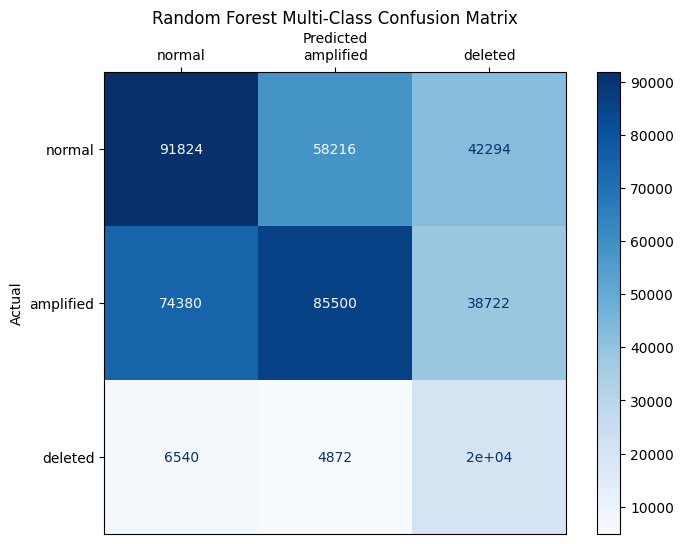

In [24]:
# Split data into training and test sets
X = combined_data.drop(columns=['status'])  # Features (drop the target column)
y = combined_data['status']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train the model
# Helps handle class imbalance by assigning more weight to underrepresented classes
model = RandomForestClassifier(class_weight='balanced', n_jobs=4, random_state=42)
model.fit(X_train, y_train)

# Get predicted values for evaluating model performance
y_pred = model.predict(X_test)

# Create a multi-class confusion matrix
# Visualize how well the model predicts each class (normal, amplified, deleted)
cm = confusion_matrix(y_test, y_pred, labels=['normal', 'amplified', 'deleted'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['normal', 'amplified', 'deleted'])
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues')

# Move x-axis labels to the top
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax.set_xlabel("Predicted")

# Set the y-axis label and tick labels for both axes
ax.set_ylabel("Actual")
ax.set_xticklabels(['normal', 'amplified', 'deleted'])
ax.set_yticklabels(['normal', 'amplified', 'deleted'])

plt.title("Random Forest Multi-Class Confusion Matrix")
plt.show()

In [26]:
# Calculate precision, recall, and F1 scores for each class
print("Classification Report for Random Forest Multi-Class Model:")
print(classification_report(y_test, y_pred, target_names=['normal', 'amplified', 'deleted']))

Classification Report for Random Forest Multi-Class Model:
              precision    recall  f1-score   support

      normal       0.58      0.43      0.49    198602
   amplified       0.20      0.64      0.30     31483
     deleted       0.53      0.48      0.50    192334

    accuracy                           0.47    422419
   macro avg       0.44      0.52      0.43    422419
weighted avg       0.53      0.47      0.48    422419



**Summary of Confusion Matrix Results**

Normal Class:

- True Positives (correctly classified as normal): 91,824
- Misclassified as Amplified: 58,216
- Misclassified as Deleted: 42,294

Amplified Class:
- True Positives (correctly classified as amplified): 85,500
- Misclassified as Normal: 74,380
- Misclassified as Deleted: 38,722

Deleted Class:
- True Positives (correctly classified as deleted): 20,000
- Misclassified as Normal: 6,540
- Misclassified as Amplified: 4,872

**Observations**

Class Imbalance Effects:
- The "deleted" class has a much smaller representation compared to "normal" and "amplified," which results in a higher rate of misclassifications for "deleted" genes.
- Although the classifier captures 20,000 "deleted" genes correctly, it still misclassifies a significant portion of them as "normal" or "amplified," likely due to the class imbalance and scarcity of "deleted" examples.

Cross-Class Confusion:
- There’s substantial misclassification between "normal" and "amplified." This could indicate overlapping feature patterns or insufficient differentiation between these two classes.

**Binary Classification with Random Forest: Normal vs Amplified**

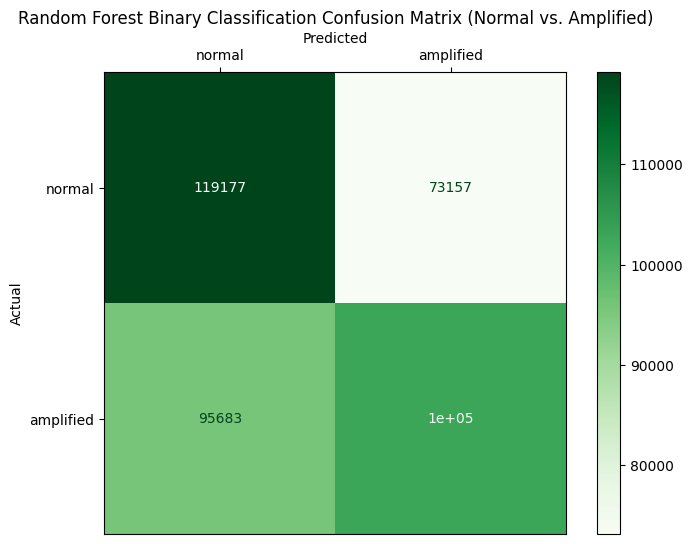

In [28]:
# Exclude 'deleted' records and train on only 'normal' and 'amplified'
binary_data = combined_data[combined_data['status'] != 'deleted']
X_binary = binary_data.drop(columns=['status'])  # Features (drop the target column)
y_binary = binary_data['status']

# Split the binary dataset
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_binary, y_binary, test_size=0.2, stratify=y_binary, random_state=42)

# Train a new binary classification model
binary_model = RandomForestClassifier(class_weight='balanced', n_jobs=4, random_state=42)
binary_model.fit(X_train_bin, y_train_bin)

# Predict on the binary test set and create a confusion matrix
y_pred_bin = binary_model.predict(X_test_bin)
cm_bin = confusion_matrix(y_test_bin, y_pred_bin, labels=['normal', 'amplified'])

# Create a binary confusion matrix with similar styling to the multi-class version
disp = ConfusionMatrixDisplay(confusion_matrix=cm_bin, display_labels=['normal', 'amplified'])
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Greens')

# Move x-axis labels to the top
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax.set_xlabel("Predicted")

# Set the y-axis label and tick labels for both axes
ax.set_ylabel("Actual")
ax.set_xticklabels(['normal', 'amplified'])
ax.set_yticklabels(['normal', 'amplified'])

plt.title("Random Forest Binary Classification Confusion Matrix (Normal vs. Amplified)")
plt.show()

In [30]:
# Calculate precision, recall, and F1 scores for each class
print("Classification Report for Random Forest Binary Class Model:")
print(classification_report(y_test_bin, y_pred_bin, target_names=['normal', 'amplified']))

Classification Report for Random Forest Binary Class Model:
              precision    recall  f1-score   support

      normal       0.58      0.52      0.55    198601
   amplified       0.55      0.62      0.59    192334

    accuracy                           0.57    390935
   macro avg       0.57      0.57      0.57    390935
weighted avg       0.57      0.57      0.57    390935



**Summary of the Confusion Matrix Results**

- True Positives for Normal: 119,177 genes correctly classified as normal.
- True Positives for Amplified: 100,000 genes correctly classified as amplified.
- Misclassified as Amplified (False Positives): 73,157 genes labeled as normal were predicted as amplified.
- Misclassified as Normal (False Negatives): 95,683 genes labeled as amplified were predicted as normal.

**Observations**

High True Positive Counts:
- The model correctly identifies a large number of both "normal" and "amplified" genes, suggesting that it has learned to differentiate between the two classes reasonably well.

Significant Misclassifications:
- There is a high number of misclassifications in both directions:
    - 73,157 "normal" genes are misclassified as "amplified."
    - 95,683 "amplified" genes are misclassified as "normal."
- This could indicate some overlap or similarity in the features of these two classes, making it challenging for the model to fully distinguish between them.

Balanced Performance:
- Despite the misclassifications, the model appears to perform comparably for both classes, with a roughly similar number of true positives and false classifications in each direction.

**Multi-classification: XGBoost**

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:51:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


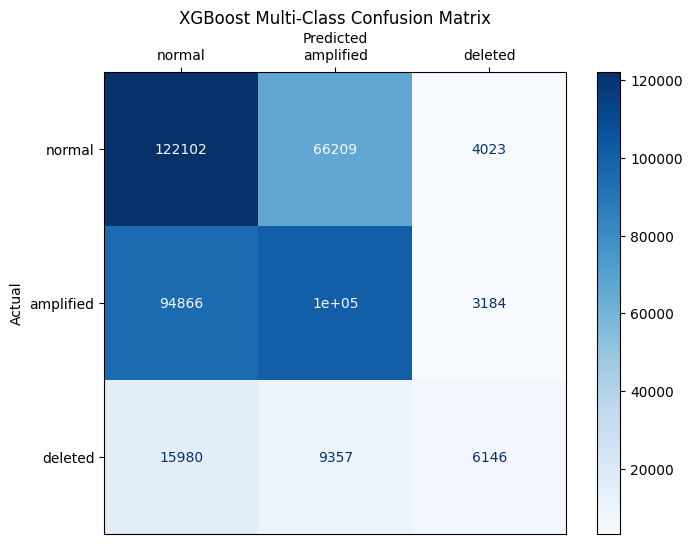

Classification Report:
              precision    recall  f1-score   support

      normal       0.57      0.51      0.54    198602
   amplified       0.46      0.20      0.27     31483
     deleted       0.52      0.63      0.57    192334

    accuracy                           0.54    422419
   macro avg       0.52      0.45      0.46    422419
weighted avg       0.54      0.54      0.53    422419



In [39]:
# Encode target labels as integers
le = LabelEncoder()
y_encoded = le.fit_transform(combined_data['status'])  # Convert 'status' to numeric

# Split data into training and test sets
X = combined_data.drop(columns=['status'])  # Features
y = y_encoded  # Encoded target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train an XGBoost multi-class model
model = XGBClassifier(
    objective='multi:softprob',  # For multi-class classification
    eval_metric='mlogloss',      # Multi-class log loss
    use_label_encoder=False,     
    scale_pos_weight=1,          # Adjust if class imbalance is severe; experiment with this if needed
    learning_rate=0.1,
    n_estimators=100,
    max_depth=6,
    random_state=42
)
model.fit(X_train, y_train)

# Get predicted values for evaluating model performance
y_pred = model.predict(X_test)

# Decode predictions and actual values back to categorical labels for the confusion matrix display
y_test_categorical = le.inverse_transform(y_test)
y_pred_categorical = le.inverse_transform(y_pred)

# Create a multi-class confusion matrix with categorical labels
cm = confusion_matrix(y_test_categorical, y_pred_categorical, labels=['normal', 'amplified', 'deleted'])

# Visualize the confusion matrix with categorical labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['normal', 'amplified', 'deleted'])
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues')

# Move x-axis labels to the top
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax.set_xlabel("Predicted")

# Set the y-axis label and tick labels for both axes
ax.set_ylabel("Actual")
ax.set_xticklabels(['normal', 'amplified', 'deleted'])
ax.set_yticklabels(['normal', 'amplified', 'deleted'])

plt.title("XGBoost Multi-Class Confusion Matrix")
plt.show()

# Print classification report with categorical labels
print("Classification Report:")
print(classification_report(y_test_categorical, y_pred_categorical, target_names=['normal', 'amplified', 'deleted']))

**Summary of results**

- XGBoost demonstrates improved classification accuracy for the normal and amplified classes compared to Random Forest. It has fewer misclassifications of "normal" and "amplified" as "deleted," which could indicate a better separation between the "deleted" and other classes.

- Deleted Class Challenge: XGBoost performs worse in correctly identifying the "deleted" class, with more instances misclassified as "normal" or "amplified." Random Forest outperforms XGBoost specifically for the "deleted" class.

**Binary Classification with XGBoost: Normal vs Amplified**

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:04:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


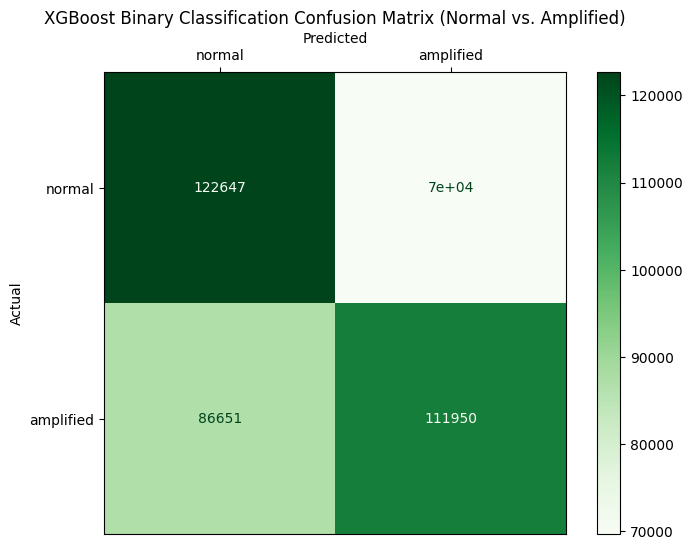

Binary Classification Report (Normal vs. Amplified):
              precision    recall  f1-score   support

   amplified       0.62      0.56      0.59    198601
      normal       0.59      0.64      0.61    192334

    accuracy                           0.60    390935
   macro avg       0.60      0.60      0.60    390935
weighted avg       0.60      0.60      0.60    390935



In [41]:
# Prepare the data for binary classification (excluding 'deleted')
binary_data = combined_data[combined_data['status'] != 'deleted']
X_binary = binary_data.drop(columns=['status']) 
y_binary = binary_data['status']

# Encode target labels for binary classification
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_binary_encoded = le.fit_transform(y_binary)

# Split data
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_binary, y_binary_encoded, test_size=0.2, stratify=y_binary_encoded, random_state=42)

# Train the XGBoost binary classifier
binary_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=1,
    learning_rate=0.1,
    n_estimators=100,
    max_depth=6,
    random_state=42
)
binary_model.fit(X_train_bin, y_train_bin)

# Predict
y_pred_bin = binary_model.predict(X_test_bin)

# Decode the binary predictions and actual labels for consistent labeling
y_test_bin_categorical = le.inverse_transform(y_test_bin)
y_pred_bin_categorical = le.inverse_transform(y_pred_bin)

# Create a confusion matrix for binary classification with categorical labels
cm_bin = confusion_matrix(y_test_bin_categorical, y_pred_bin_categorical, labels=['normal', 'amplified'])

# Visualize the binary confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp_bin = ConfusionMatrixDisplay(confusion_matrix=cm_bin, display_labels=['normal', 'amplified'])
disp_bin.plot(ax=ax, cmap="Greens")

# Move x-axis labels to the top
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax.set_xlabel("Predicted")

# Set the y-axis label and tick labels for both axes
ax.set_ylabel("Actual")
ax.set_xticklabels(['normal', 'amplified'])
ax.set_yticklabels(['normal', 'amplified'])

plt.title("XGBoost Binary Classification Confusion Matrix (Normal vs. Amplified)")
plt.show()

print("Binary Classification Report (Normal vs. Amplified):")
print(classification_report(y_test_bin, y_pred_bin, target_names=le.classes_))

**Observations**

- The model demonstrates balanced performance but still shows significant misclassifications between "normal" and "amplified."
- The high number of misclassifications in both directions suggests that "normal" and "amplified" classes may have overlapping features, making them challenging to distinguish.